# Find digits on display

The following code is meant to lead you through the steps required to learn what numbers are written on a numberpad on an image which is a frame of a video.

The first block imports everything needed for the following code

In [267]:
from imutils.perspective import four_point_transform
from matplotlib import pyplot as plt
import cv2
import imutils
import statistics

This function is only a helper to compare two images visually.

In [268]:
def show_images(img, img2):
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Image one'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img2, cmap='gray')
    plt.title('Image two'), plt.xticks([]), plt.yticks([])

    plt.show()

Define the dictionary of digit segments so we can identify each digit on the thermostat.

In [258]:
DIGITS_LOOKUP = {
        (1, 1, 1, 0, 1, 1, 1): 0,
        (0, 0, 1, 0, 0, 1, 0): 1,
        (1, 0, 1, 1, 1, 1, 0): 2,
        (1, 0, 1, 1, 0, 1, 1): 3,
        (0, 1, 1, 1, 0, 1, 0): 4,
        (1, 1, 0, 1, 0, 1, 1): 5,
        (1, 1, 0, 1, 1, 1, 1): 6,
        (1, 0, 1, 0, 0, 1, 0): 7,
        (1, 1, 1, 1, 1, 1, 1): 8,
        (1, 1, 1, 1, 0, 1, 1): 9
        }

In [259]:
# load the example image
image = cv2.imread('../assets/example.png')

#################
# Preprocessing #
#################

# resize the image
image = imutils.resize(image, height=500)
# only use approximately the part of the image in
# which the display should be visible.
x, y, w, h = (400, 240, 200, 100)
image = image[y:y + h, x:x + w]
# grayscale the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blurring the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# compute an edge map
edged = cv2.Canny(blurred, 255, 100)

Lets look at the part of the image we choose and compare the imagepart to the edge map we computed of it.  
This should now display a quite nice square which is sufficient to find the panels position quite accurate.

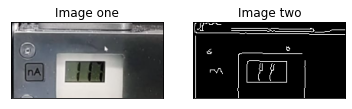

In [260]:
show_images(image, edged)

In [261]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if the contour has four vertices, then we have found
    # the thermostat display
    if len(approx) == 4:
        displayCnt = approx
        break

# extract the thermostat display, apply a perspective transform to it
output = four_point_transform(image, displayCnt.reshape(4, 2))
warped = four_point_transform(gray, displayCnt.reshape(4, 2))

# cut off the borders of the image/display
width, height = output.shape[1], output.shape[0] - 2
x, y, w, h = (1, 1, width - 2, height - 2)
output = output[y:y + h, x:x + w]
warped = warped[y:y + h, x:x + w]

Lets look at the result we got again.  
Here we'd expect that the quite exact display part of the image was found.

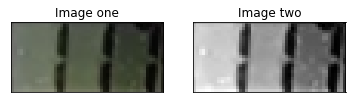

In [262]:
show_images(output, warped)

In [263]:
# threshold the warped image, then apply a series of morphological
# operations to cleanup the thresholded image
tt = 45
thresh = cv2.threshold(warped, tt, 255, cv2.THRESH_BINARY)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 10))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

Lets look at the result again.  
After applying threshold the image should be black and white.

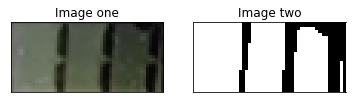

In [264]:
show_images(output, thresh)

The following step assumes that there are three numbers on the panel equally distributed.  
`cnts` is a list of the dimensions for the three panel parts.

Then it loops over each digit and each segment of the number trying to find out if there is a bar.

In [265]:
digits = []

# use a third of the panel for each number
width, height = thresh.shape[1], thresh.shape[0] - 2
num_width = width // 3
cnts = [
    (2, 0, num_width, height),
    (num_width + 2, 0, num_width, height),
    (2 * num_width + 2, 0, num_width - 3, height)]

# loop over each of the digits
for contour in cnts:
    # extract the digit ROI
    (x, y, w, h) = contour
    roi = thresh[y:y + h, x:x + w]
    # compute the width and height of each of the 7 segments
    # we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
    # define the set of 7 segments
    segments = [
        ((0, 0), (w, dH)),  # top
        ((0, 0), (dW, h // 2)),  # top-left
        ((w - dW, 0), (w, h // 2)),  # top-right
        ((0, (h // 2) - dHC), (w, (h // 2) + dHC)),  # center
        ((0, h // 2), (dW, h)),  # bottom-left
        ((w - dW, h // 2), (w, h)),  # bottom-right
        ((0, h - dH), (w, h))  # bottom
    ]
    on = [0] * len(segments)
    
    num_roi = []
    # loop over the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of
        # thresholded pixels in the segment, and then compute
        # the area of the segment
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB - xA) * (yB - yA)
        
        # print(total / float(area))
        num_roi.append(total / float(area))
    
    # print(statistics.mean(num_roi))
    # TODO: test if using the mean of rois works for
    # correcting the light difference for each section
    for i, roi in enumerate(num_roi):
        if roi < statistics.mean(num_roi):
            on[i] = 1

    # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    # print(tuple(on))
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    cv2.rectangle(thresh, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(thresh, str(digit), (x - 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

117 nA


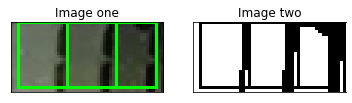

In [266]:
# display the digits
print(u"{}{}{} nA".format(*digits))

# TODO: here the tt (threshold) has to be set right
show_images(output, thresh)